# RQ1. How interpretabilities are consistent?

1. Variability across Seeds
2. Comparison of Saliency map across: XAI Methods, Architectures, Tasks (Age reg vs. cls)
3. Compare with Traditional Methods: Fastsurfer Segmentation, VBM

In [1]:
import matplotlib.pyplot as plt

import weight_parser as wp
import stats as s
import constants as C
import plotting as p
import metadata as m
import utils as u

## 1. Variability across seeds (=intra-model)

Pipeline
1. Earn Projections on DKT+ASEG ATLAS
    - This is done in inference phase
2. Calculate SpearmanR correlation between seeds 
3. Plot down triangle heatmap

In [2]:
# Loading Saliencies
# Exceptions: Convnext-base seeds are only 42, 43 and IG not provided for convnext-base
xai_pivot = dict()
xai_avgs = dict()
for xai_method in C.XAI_METHODS:
    xai_avg = [wp.WeightAvg(model_name=model_name,
                            xai_method=xai_method,
                            seeds=[42, 43, 44] if model_name != "convnext-base" else [42, 43])
               for model_name in (C.MODELS if xai_method != "ig" else C.MODELS[:-1])]
    xai_avgs[xai_method] = xai_avg
    xai_corr, xai_pval = s.spearmanr_permutation(weight_avgs=xai_avg)
    xai_pivot[xai_method] = xai_corr

INFO:/home/1pha/codespace/brain-age-prediction/RQ/weight_parser.py:Load all seeds: [42, 43, 44]
/home/1pha/.conda/envs/age/lib/python3.10/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


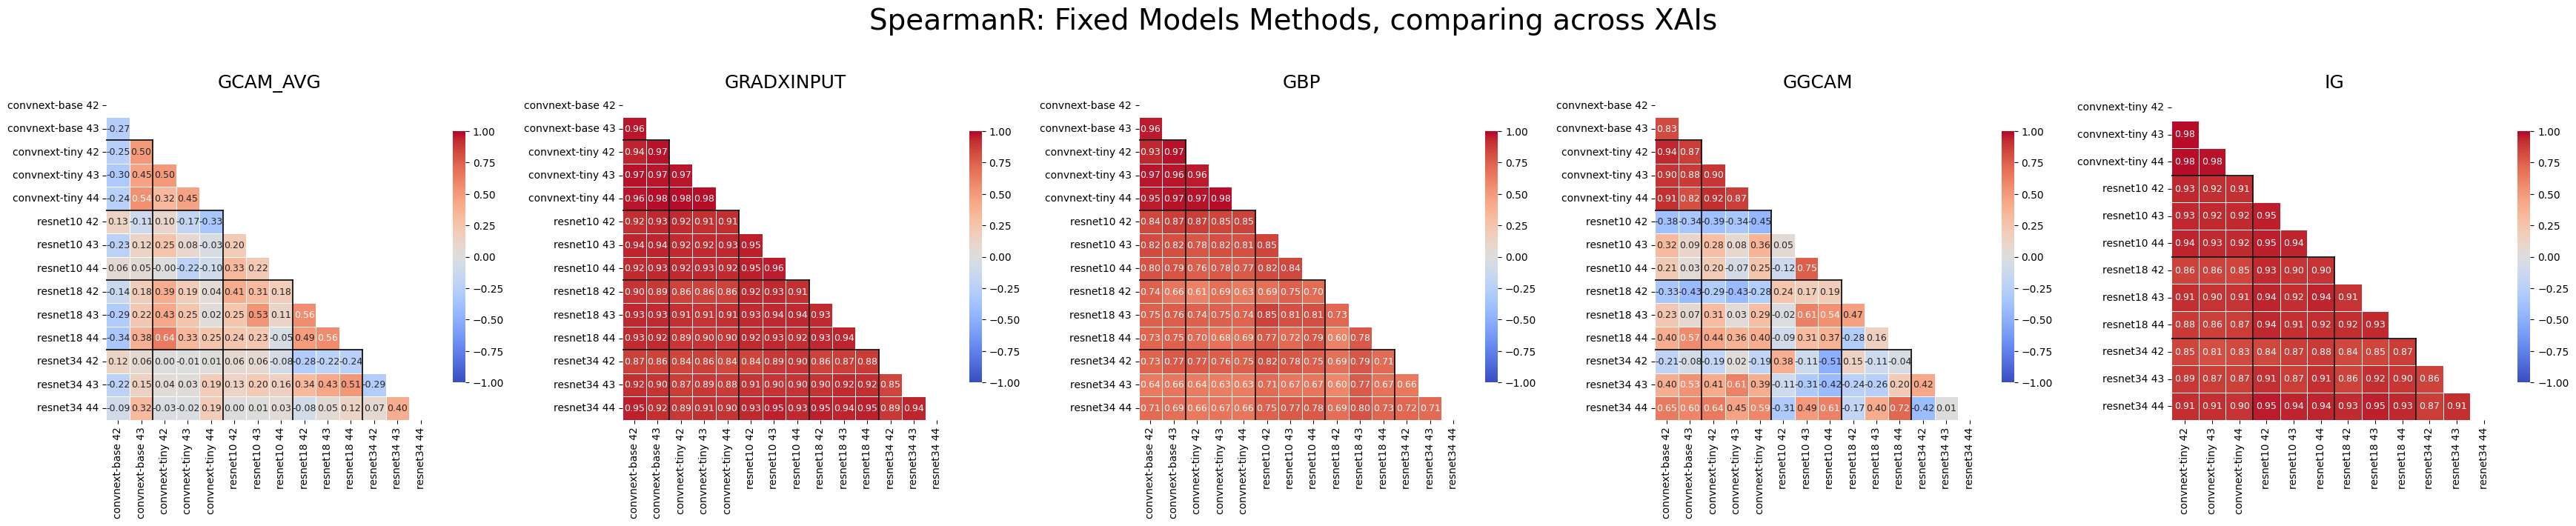

In [9]:
fig, ax = plt.subplots(ncols=5, figsize=(35, 7))
for i, xai_method in enumerate(xai_pivot):
    p.plot_corr(corr=xai_pivot[xai_method], subtitle=xai_method.upper(), subtitle_size=18, cbar_size=0.6, ax=ax[i])
fig.suptitle("SpearmanR: Fixed Models Methods, comparing across XAIs", size=28);
fig.tight_layout()

## 2. Variability Across Models (fixed Model, different XAI Method)

In [4]:
# Load Saliencies
model_pivot = dict()
model_avgs = dict()
for i, model in enumerate(C.MODELS):
    seeds = [42, 43] if model == "convnext-base" else [42, 43, 44]
    _xai_methods = C.XAI_METHODS[:-1] if model == "convnext-base" else C.XAI_METHODS
    avgs = [wp.WeightAvg(model_name=model, xai_method=xai_method, seeds=seeds) for xai_method in _xai_methods]
    model_avgs[model] = avgs
    
    corr, pval = s.spearmanr_permutation(avgs, naming="xai")
    model_pivot[model] = corr

/home/1pha/.conda/envs/age/lib/python3.10/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


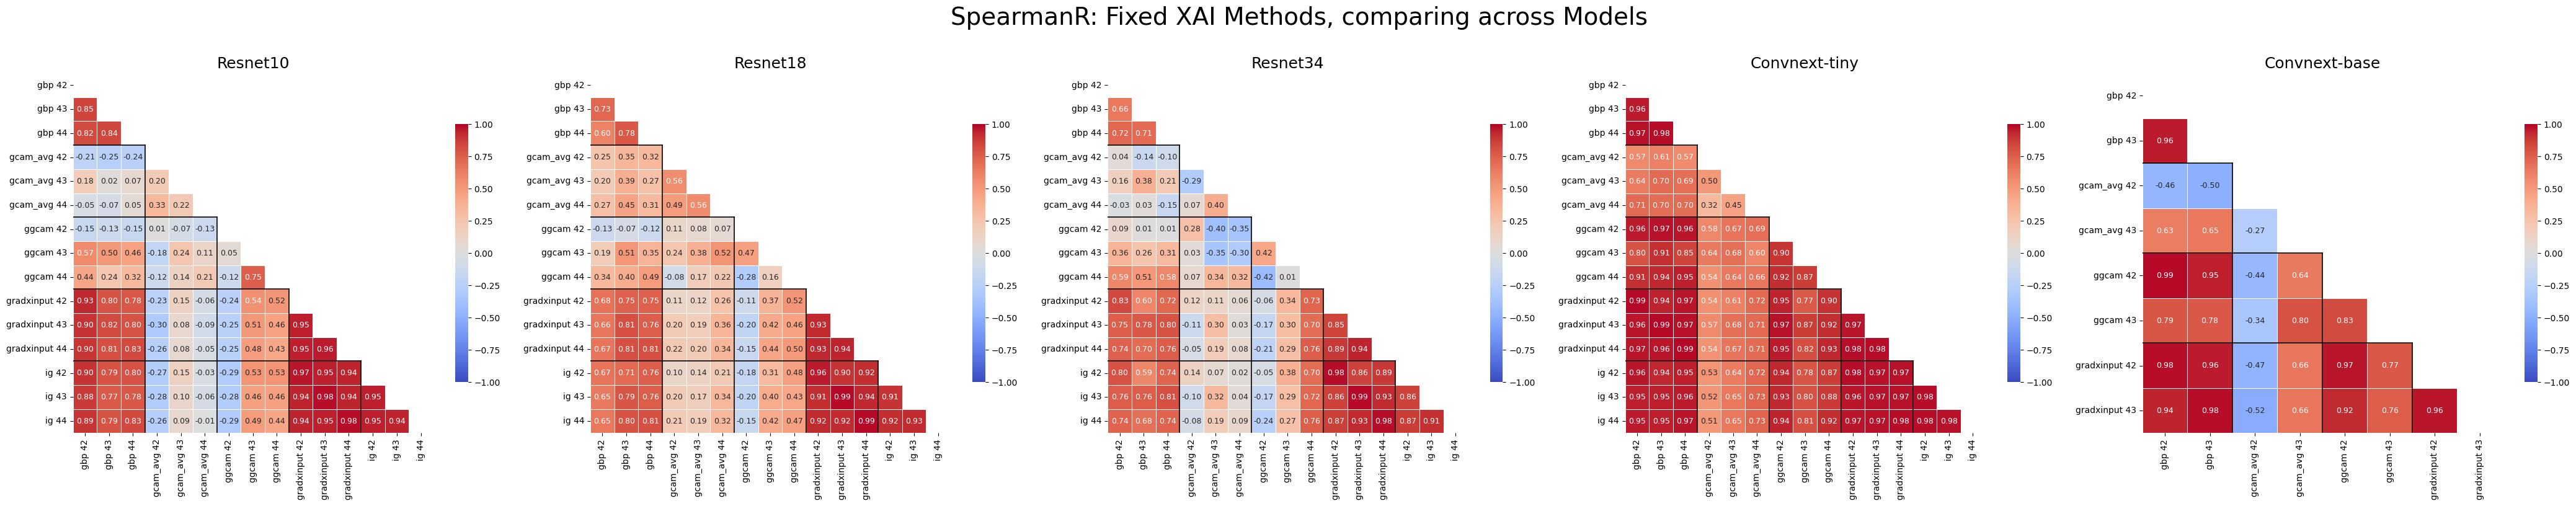

In [5]:
fig, ax = plt.subplots(ncols=5, figsize=(42, 8))
for i, model in enumerate(model_pivot):
    p.plot_corr(corr=model_pivot[model], subtitle=model.capitalize(), subtitle_size=18, cbar_size=0.6, ax=ax[i])
fig.suptitle("SpearmanR: Fixed XAI Methods, comparing across Models", size=28);
fig.tight_layout()

## 3. Comparisons against Conventional Methods (Fastsurfer Segmentation, VBM analysis)

In [6]:
meta_dicts = m.load_metadata()

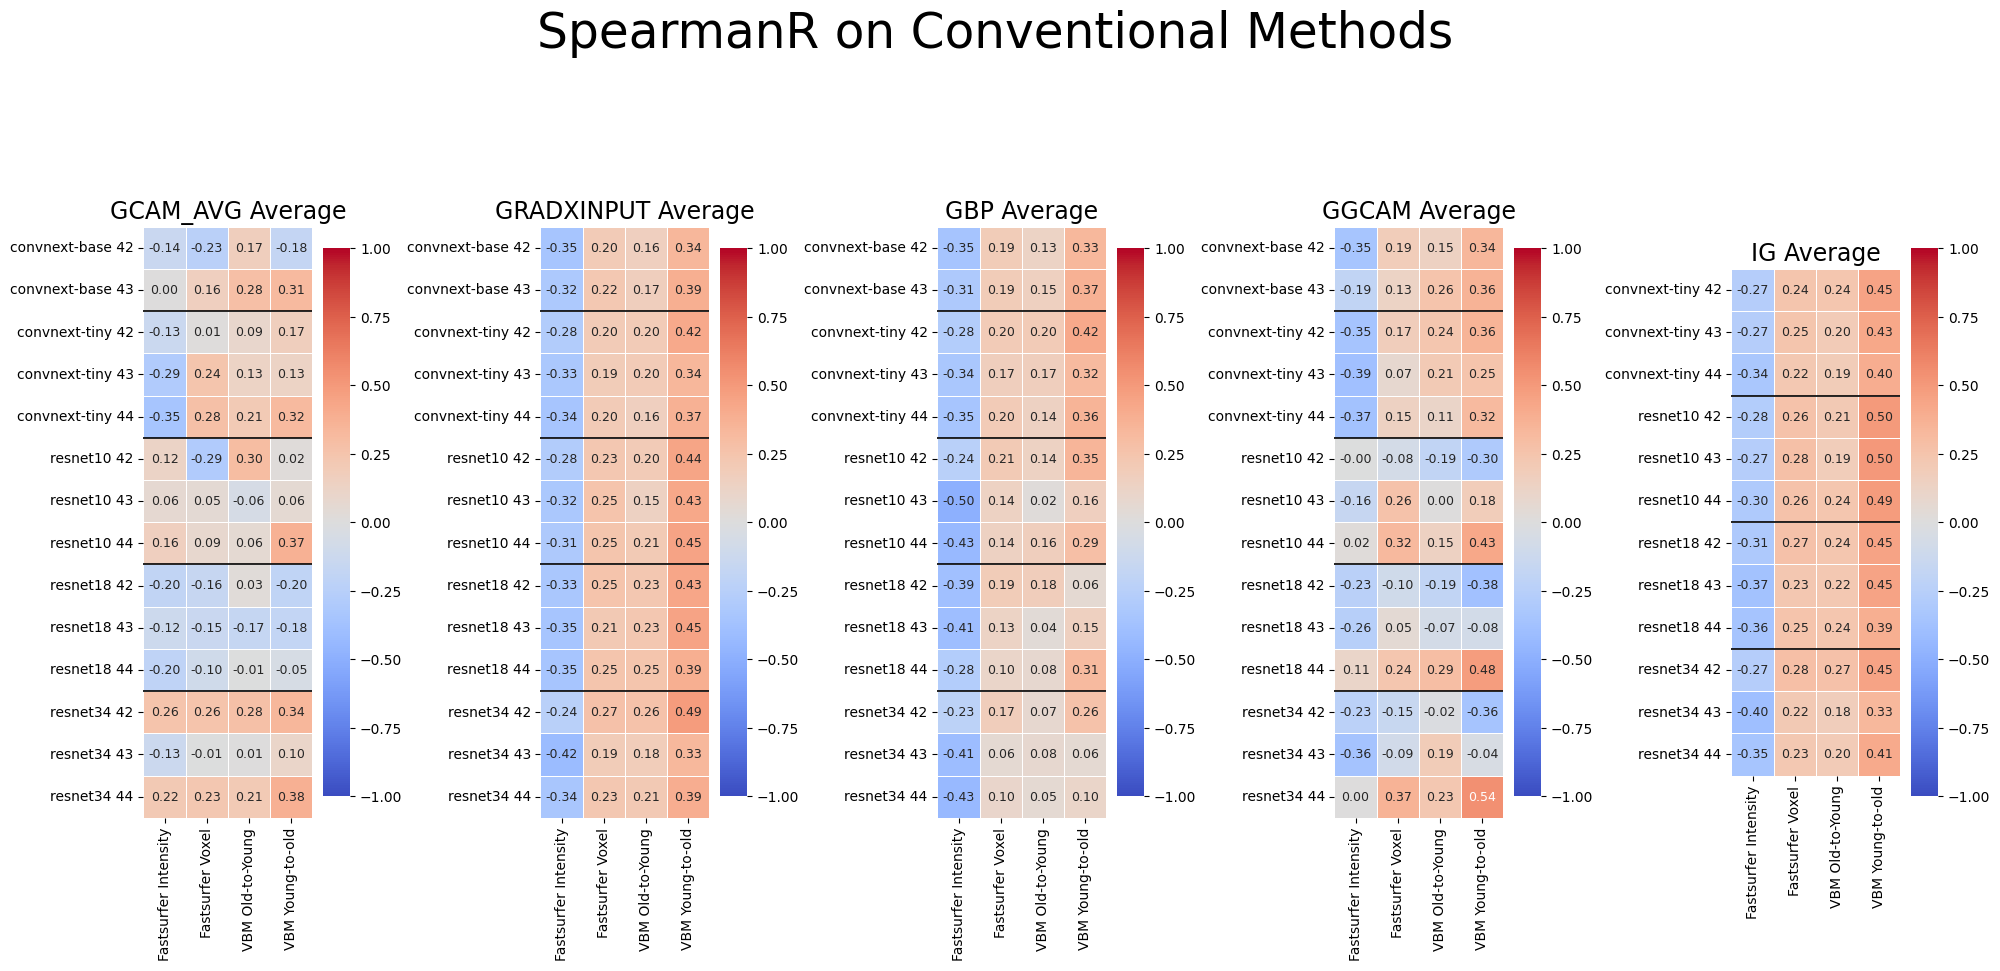

In [7]:
fig, ax = plt.subplots(ncols=5, figsize=(20, 11))
for i, xai_method in enumerate(xai_avgs):
    corrs, pvals = s.spearmanr_vs(weight_avgs=xai_avgs[xai_method], meta_dicts=meta_dicts)
    p.plot_corr(corrs, hide_triu=False, ax=ax[i], cbar_size=0.6,
                use_cbar=True, subtitle=f"{xai_method.upper()} Average",
                subtitle_size=17)
fig.suptitle("SpearmanR on Conventional Methods", size=35)
fig.tight_layout()

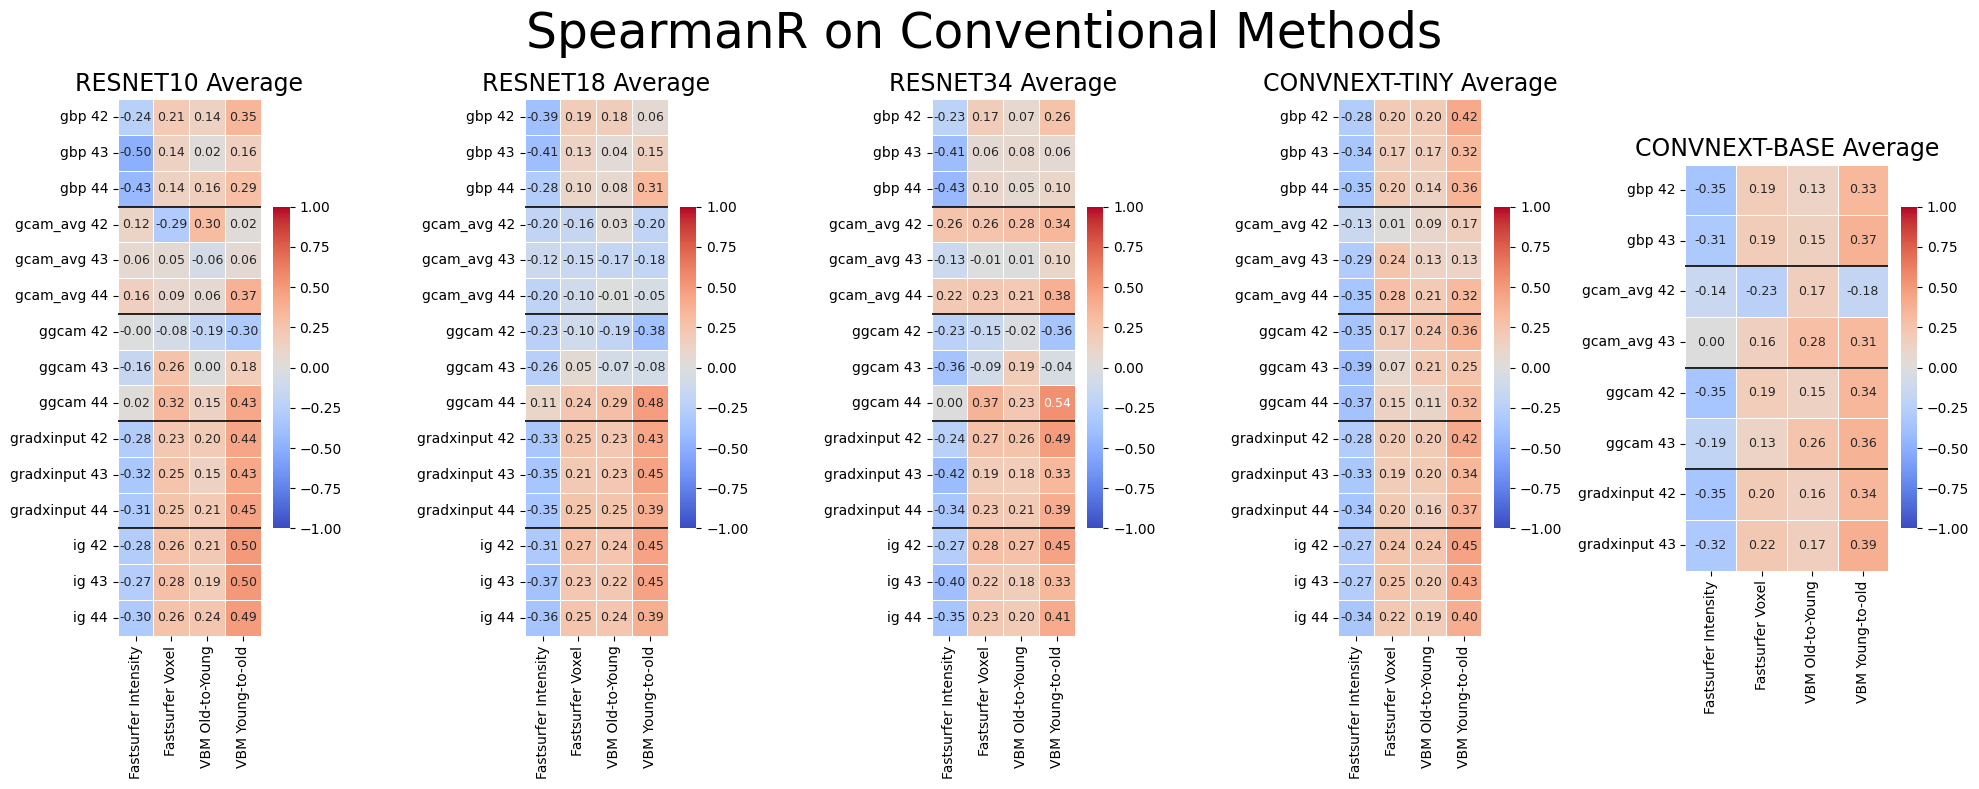

In [8]:
fig, ax = plt.subplots(ncols=5, figsize=(20, 8))
for i, model in enumerate(model_avgs):
    corrs, pvals = s.spearmanr_vs(weight_avgs=model_avgs[model], meta_dicts=meta_dicts, naming="model")
    p.plot_corr(corrs, hide_triu=False, ax=ax[i], cbar_size=0.6,
                use_cbar=True, subtitle=f"{model.upper()} Average",
                subtitle_size=17)
fig.suptitle("SpearmanR on Conventional Methods", size=35)
fig.tight_layout()